In [5]:
import numpy as np
from hello.pid.lvpid import PIDController
from hello.pid.delay import seconds, minutes, hours, days, m2s, s2m, h2s, DelayBuffer, DelaySink
from hello.pid.gas_process import HeadspaceProcess, GasController
from hello.pid.do_simulation.doprocess import DOProcess, AIR_CNO

from hello.pid.do_simulation.options import SimOps, SimConfig
from hello.pid.picker import mk_picker
from hello.pid.do_simulation.sim_window import PIDSimFrame
from hello.pid.ui import TkQuitHack
from hello.pid.do_simulation.do_sim import do_sim_coroutine, do_sim
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter
%matplotlib
from matplotlib import pyplot as plt
import itertools

Using matplotlib backend: TkAgg


In [6]:
k_80L = 0.1306
k_15L = 0.19314
k_3L  = 0.24286

ops = SimOps()
ops.o2_pid.p = 3
ops.o2_pid.i = 70
ops.o2_pid.d = 0
ops.o2_pid.amax = 100
ops.o2_pid.amin = 0
ops.o2_pid.beta = 0
ops.o2_pid.linearity = 1
ops.o2_pid.alpha = -1

ops.n2_pid.p = -3
ops.n2_pid.i = 70
ops.n2_pid.d = 0
ops.n2_pid.amax = 100
ops.n2_pid.amin = 0
ops.n2_pid.beta = 0
ops.n2_pid.linearity = 1
ops.n2_pid.alpha = -1

ops.mfcs.co2_max = 1
ops.mfcs.o2_max = 2
ops.mfcs.n2_max = 10
ops.mfcs.air_max = 10

ops.plots.xscale = 'auto'
ops.plots.xmin = 0
ops.plots.xmax = 72
ops.plots.xscale_factor = 3600

ops.delay = 0
ops.end = 20*hours
ops.initial_actual_cno = (0.0004, .78, .21)
ops.initial_request_cno = (0.00, 0, 0)
ops.initial_pv = 100
ops.set_point = 150
ops.set_point_deadband = 1
ops.k_mult = 1.1
ops.k = k_80L
ops.c = 0
ops.dc = 0
ops.d2c = 0
ops.mode = "o2a"
ops.main_gas = 2.0
ops.reactor_size = 80
ops.reactor_volume = 57
ops.time_unit = hours
ops.max_iters = 3 * days

In [7]:
def fmt_rel_params(ops=ops):
    rel = []
    a = rel.append
    for c in "o2", "n2":
        for p in "p i d".split():
            ct = c+"_pid"
            v = getattr(ops, ct)
            v = getattr(v, p)
            a("%s.%s = %r" % (ct, p, v))
    for c in "co2 o2 n2 air".split():
        v = getattr(ops.mfcs, c+"_max")
        a("mfcs.%s_max = %r"%(c,v))
    mo = "k k_mult main_gas end"
    for m in mo.split():
        a("%s = %r"%(m, getattr(ops, m)))
    for m in "c dc d2c".split():
        v = getattr(ops, m)
        if v != 0:
            a("%s=%r"%(m, v))
    return "\n".join(rel)

In [8]:
def np_unpack(l):
    return [np.array(data) for data in list(zip(*l))]

ax_list2 = []
fig = None

def axes():
    return ax_list2

def setup2(new=False):
    global fig, ax1, ax2, ax3, ax4, ax5, ax6
    global ax_list2
    
    if not plt.get_fignums() or new or not fig:
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        #ax2 = fig.add_subplot(2,1,2)
        ax2 = ax1.twinx()
        ax_list2 = [ax1, ax2]
        for a in axes():
            b = a.get_position()
            a.set_position([b.x0, b.y0+.1, b.width*.95, b.height*.9])
            a.grid()
    else:
        for a in axes():
            a.clear()
            a.grid()
        for t in fig.texts:
            t.remove()
    
def test2(ops):
    d1, d2, d3 = do_sim(ops)
    x, pv, _, _, n2, o2, *_, o2a = np_unpack(d1)
    return x,pv, n2, o2, o2a*100/0.21

def _p1(ax, x, y, color, label, ylabel=None):
    ax.plot(x,y, color=color, label=label)
    if ylabel: ax.set_ylabel(ylabel)

def plot2(x, pv, n2, o2, o2a):
    _p1(ax1, x, pv, "blue", "pv", "DO (%)")
    _p1(ax2, x, o2, "green", "O2", "Gas Flow (%)")
    _p1(ax2, x, n2, "red", "N2")
    
    ax1.axhline(y=ops.set_point, ls="--", color="black")
    ax1.axhline(y=ops.set_point-ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.axhline(y=ops.set_point+ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "%d%%"%(y*100)))
    
    h = []
    l = []
    for a in axes():
        a.xaxis.set_major_locator(MultipleLocator(1))
        h_, l_ = a.get_legend_handles_labels()
        h.extend(h_)
        l.extend(l_)
    ax1.legend(h, l, loc="center", ncol=3, bbox_to_anchor=(0.5, -.18))
    
    ax1.set_xlabel("Time (hr)")
    
    fig.canvas.flush_events()
    fig.canvas.draw()
    
def finish2():
    for a in axes():
        if a.legend_:
            mk_picker(fig, a)
    
def run2(ops):
    x, pv, n2, o2, o2a = test2(ops)
    plot2(x, pv, n2, o2, o2a)
    finish2()

In [9]:
# ax_list3 = []
# fig3 = None

# def axes3():
#     return ax_list3

# def setup3(new=False):
#     global fig3, ax31, ax32, ax33, ax34, ax35, ax36
#     global ax_list3
    
#     if not plt.get_fignums() or new or not fig3:
#         fig3 = plt.figure()
#         ax31 = fig3.add_subplot(2,1,1)
#         ax32 = ax31.twinx()
        
#         ax33 = fig3.add_subplot(2,1,2)
#         ax34 = ax33.twinx()
        
#         ax_list3 = [ax31, ax32, ax33, ax34]
#         for a in axes3():
#             b = a.get_position()
#             a.set_position([b.x0, b.y0+.1, b.width*.95, b.height*.9])
#             a.grid()
#     else:
#         for a in axes3():
#             a.clear()
#             a.grid()
#         for t in fig3.texts:
#             t.remove()
            
# def plot3(x, pv, n2, o2, o2a):
#     _p1(ax1, x, pv, "blue", "pv", "DO (%)")
#     _p1(ax2, x, o2, "green", "O2", "Gas Flow (%)")
#     _p1(ax2, x, n2, "red", "N2")
    
#     ax1.axhline(y=ops.set_point, ls="--", color="black")
#     ax1.axhline(y=ops.set_point-ops.set_point_deadband, ls="--", color="black", lw=0.5)
#     ax1.axhline(y=ops.set_point+ops.set_point_deadband, ls="--", color="black", lw=0.5)
#     ax1.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
#     ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "%d%%"%(y*100)))
    
#     h = []
#     l = []
#     for a in axes():
#         a.xaxis.set_major_locator(MultipleLocator(1))
#         h_, l_ = a.get_legend_handles_labels()
#         h.extend(h_)
#         l.extend(l_)
#     ax1.legend(h, l, loc="center", ncol=3, bbox_to_anchor=(0.5, -.18))
    
#     ax1.set_xlabel("Time (hr)")
    
#     fig.canvas.flush_events()
#     fig.canvas.draw()

#### More tuning.....

In [10]:
def set_win_sz(win, x,y):
    w, h = 565,433
    w *= 0.8
    h *= 0.8
    win.geometry('%dx%d+%d+%d'%(w, h, x,y))

def rampup(ops, x, y):
    setup2(True)
    ops.set_point = 150
    ops.initial_pv = 100
    run2(ops)
    ax1.set_xlim(0, 20)
    ax1.set_ylim(140, 160)
    a,b = ax2.set_ylim()
    ax2.set_ylim(0, b)
    ax1.set_title("Ramp Up: Gradual")
    w=fig.canvas._tkcanvas.master
    set_win_sz(w, x, y)
    
def rampdown(ops, x, y):
    setup2(True)
    ops.set_point = 50
    ops.initial_pv = 100
    run2(ops)
    ax1.set_xlim(0, 20)
    ax1.set_ylim(40, 60)
    ax2.set_ylim(0, 1)
    ax1.set_title("Ramp Down: Gradual")
    w=fig.canvas._tkcanvas.master
    set_win_sz(w, x, y)
    
def rampup2(ops):
    ops.set_point = 150
    ops.initial_pv = 100
    return test2(ops)
    
def rampdown2(ops):
    ops.set_point = 50
    ops.initial_pv = 100
    return test2(ops)
    
def run3(ops):
    return x, pv, n2, o2, o2a

def plot3(x, pv, n2, o2, o2a):
    c = color()
    _p1(ax1, x, pv, "blue", "pv", "DO (%)")
    _p1(ax2, x, o2, "green", "O2", "Gas Flow (%)")
    _p1(ax2, x, n2, "red", "N2")
    
    ax1.axhline(y=ops.set_point, ls="--", color="black")
    ax1.axhline(y=ops.set_point-ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.axhline(y=ops.set_point+ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "%d%%"%(y*100)))
    
    h = []
    l = []
    for a in axes():
        a.xaxis.set_major_locator(MultipleLocator(1))
        h_, l_ = a.get_legend_handles_labels()
        h.extend(h_)
        l.extend(l_)
    ax1.legend(h, l, loc="center", ncol=3, bbox_to_anchor=(0.5, -.18))
    
    ax1.set_xlabel("Time (hr)")
    
    fig.canvas.flush_events()
    fig.canvas.draw()

## Multiproc shotgun code below...

In [6]:
def pid_iter():
    def lr(a,b, s=1):
        return list(range(a,b+s,s))
    p  = lr(1, 10) + lr(12, 20, 2)
    i = lr(40, 120, 5)
    for o2p in p:
        for n2p in p:
            n2p = -n2p
            for o2i in i:
                for n2i in i:
                    yield o2p, n2p, o2i, n2i


def take_n(ob, n):
    it = [iter(ob)]*n
    return itertools.zip_longest(*it, fillvalue=None)

In [7]:
o = "OVERRIDE"
if 'bdata' in globals() and bdata:
    r = input("Input %s to continue data reset: "%o)
else:
    r = o
    
if r == o:
    print("Resetting data!")
    best = None
    nbest = 0
    bdata = {}
    bdata2 = {}

Resetting data!


In [11]:
import pickle, socket, subprocess
from hello.pid.do_simulation.mp_shotgun import checksum, shotgun_worker

class ProcessManager():
    def __init__(self, ip, port=12368):
        self.ip = ip
        self.port = port
        self.procs = []
        
    def create(self):
        s = getsock(self.ip, self.port)
        self.port = s.getsockname()[1]+1
        p = Process(s)
        self.procs.append(p)
        return p
    
    def spawn(self):
        p = self.create()
        p.spawn()
        return p
        
    def closeall(self):
        for p in self.procs:
            p.close()
            
    __del__ = closeall
        

def mk_msg(cmd, o):
    return pickle.dumps((cmd, o))


def getsock(ip, port):
    p = port
    while True:
        try:
            s = socket.socket()
            s.bind((ip, p))
        except OSError:
            p += 1
            if p - port > 100:
                raise
        else:
            break
    s.listen(1)
    return s
        
class Process():
    def __init__(self, s):
        self.ip, self.port = s.getsockname()
        self.serv = s
        self.sock = None
        self.rf = None
        self.wf = None
        self.popen = None
    
    def close(self):
        if self.rf is not None: self.rf.close()
        if self.wf is not None: self.wf.close()
        if self.sock is not None: self.sock.close()
        self.rf = self.wf = self.sock = None
        
    def connect(self):
        self.sock, _ = self.serv.accept()
        self.rf = self.sock.makefile("rb")
        self.wf = self.sock.makefile("wb")
        
    def spawn(self):
        path = shotgun_worker.__file__
        cmd = "python \"%s\" %s %d" % (path, self.ip, self.port)
        self.popen = subprocess.Popen(cmd, creationflags=subprocess.CREATE_NEW_CONSOLE)
        self.connect()
        
    def write(self, cmd, ob=None):
        self.wf.write(mk_msg(cmd, ob))
        self.wf.flush()
    
    def read(self):
        self.wf.flush()
        cmd, ob = pickle.load(self.rf)
        return cmd, ob
    
    def start(self, l, ops):
        for args in l:
            self.send_args(args)
        self.end_args()
        self.ack_list()
        cs = checksum.checksum(l)
        rcs = self.get_checksum()
        if cs != rcs:
            self.write("ACK_CHECKSUM", "FAILURE")
            raise ValueError("Checksum Mismatch! %r != %r"%(cs, rcs))
        self.write("ACK_CHECKSUM", "SUCCESS")
        self.write("SETUP_STATE", ops)      
        
    def get_checksum(self):
        c,o = self.read()
        if c != "VERIFY_CHECKSUM":
            raise ValueError(c)
        return o
    
    def send_args(self, args):
        self.write("ARGS", args)
        
    def end_args(self):
        self.write("END")
        
    def ack_list(self):
        cmd, ob = self.read()
        if cmd != "MSG" and ob != "ACK_LIST":
            raise ValueError("%s %s"%(cmd, ob))
        

In [9]:
import multiprocessing
nproc = multiprocessing.cpu_count()
lists = [[] for _ in range(nproc)]
for pl in take_n(pid_iter(), nproc):
    for p, l in zip(pl, lists):
        if p is not None:
            l.append(p)
            

In [10]:
import select, time

pm = ProcessManager('localhost')
ops.end = 20*hours
for i in range(nproc):
    print("Creating Process %d"%i)
    p = pm.spawn()

for l, p in zip(lists, pm.procs):
    p.start(l, ops)

m = {p.sock: p for p in pm.procs}
rl = list(m)
nback = 0
nfinish = 0
best = 9999999999999
bdata = {}

def handle(p):
    global nback, nfinish, best, bdata
    cmd, op = p.read()
    if cmd == "GOT_RESULT":
        key, score = op
        bdata[key] = score
        if 0 < score < best:  # -1 signals failed test
            best = score
            a,b,c,d = key
            print("New Best! %s.%s.%s.%s: %s" % (a,b,c,d, score))
    elif cmd == "PROC_EXIT":
        print("Process Exiting PID: %s"%op)
        endproc(p)
        nfinish += 1
    else:
        raise ValueError(cmd)
        
def endproc(p):
    del m[p.sock]
    p.close()
        
def prune():
    global m
    for p in pm.procs:
        if p.popen.poll() is not None:
            endproc(p)
            
while nfinish < nproc and m:
    rl = list(m)
    r, w, x = select.select(rl, [], [], 0)
    for s in r:
        handle(m[s])
    prune()
    time.sleep(1)

Creating Process 0
Creating Process 1
Creating Process 2
Creating Process 3
New Best! 1.-1.40.40: 2930.58016317
New Best! 1.-1.45.40: 2394.71726404
New Best! 1.-1.50.45: 1965.68809132
New Best! 1.-1.50.40: 1938.11616129
New Best! 1.-1.55.40: 1559.30660166
New Best! 1.-1.60.45: 1272.50886091
New Best! 1.-1.60.40: 1251.14081164
New Best! 1.-1.65.40: 1003.41868641
New Best! 1.-1.70.45: 825.027670978
New Best! 1.-1.70.40: 805.769902345
New Best! 1.-1.75.40: 649.902951029
New Best! 1.-1.80.45: 548.382620601
New Best! 1.-1.80.40: 529.288457834
New Best! 1.-1.85.40: 438.317860324
New Best! 1.-1.90.40: 371.789269965
New Best! 1.-1.95.40: 324.869354518
New Best! 1.-1.100.45: 310.444387945
New Best! 1.-1.100.40: 293.184103088
New Best! 1.-1.105.40: 272.67257823
New Best! 1.-1.110.40: 260.172629292
New Best! 1.-2.100.40: 253.837131033
New Best! 1.-2.105.45: 219.117722413
New Best! 1.-2.105.40: 203.493835659
New Best! 1.-2.110.40: 172.170289218
New Best! 1.-3.110.45: 164.506926414
New Best! 1.-3.1

In [12]:
import pickle
with open("do_sim_save_80L.pkl", 'wb') as f:
    ob = bdata
    pickle.dump(ob, f)

In [10]:
import pickle, os
with open("do_sim_save_80L.pkl", 'rb') as f:
    bdata = pickle.load(f)

In [14]:
l = [p for p in bdata.items() if p[1] >=0]
l.sort(key=lambda p: p[1])
top100 = l[:100]
top100

[((20, -20, 50, 40), 0.57950078394928939),
 ((18, -20, 50, 40), 0.60830104605987678),
 ((20, -20, 55, 45), 0.64809586891094928),
 ((18, -20, 55, 45), 0.73840650842695887),
 ((20, -18, 50, 40), 0.74415438679965051),
 ((20, -18, 55, 45), 0.75373209723942358),
 ((16, -20, 50, 40), 0.7587750951156389),
 ((18, -18, 50, 40), 0.76194479028212014),
 ((18, -18, 55, 45), 0.82880565691818586),
 ((20, -20, 60, 50), 0.86264298754338053),
 ((14, -20, 55, 40), 0.86344469923100964),
 ((16, -18, 50, 40), 0.88005806595615754),
 ((16, -20, 55, 40), 0.90517383839515131),
 ((12, -20, 55, 40), 0.91352167347342661),
 ((20, -16, 50, 40), 0.93514826392727968),
 ((18, -20, 55, 40), 0.93560713378629179),
 ((18, -16, 50, 40), 0.95757844828432737),
 ((20, -18, 60, 50), 0.95819018135468159),
 ((20, -20, 55, 40), 0.96197813912329377),
 ((20, -16, 55, 45), 0.97855416394784733),
 ((14, -20, 60, 45), 1.005387493967745),
 ((16, -20, 55, 45), 1.0242973800546895),
 ((16, -20, 60, 45), 1.0260534401974388),
 ((18, -16, 55, 

In [27]:
i=0
[plt.close() for i in range(20)]
for (op, n2p, oi, ni), s in top100:
    if i > 0: break
    ops.o2_pid.p = op
    ops.o2_pid.i = oi
    ops.n2_pid.p = n2p
    ops.n2_pid.i = ni

    rampup(ops, 100*i, 0)
    ax1.set_title("Ramp Up: %.3f"%s)
    ax1.set_xlim(0, 12)
    rampdown(ops, 100*i, 400)
    ax1.set_title("Ramp Down: %.3f"%s)
    ax1.set_xlim(0, 12)
    
    i += 1

In [23]:
# Slower
o2p, n2p, o2i, n2i = (20, -20, 50, 40)
ops.o2_pid.p = o2p
ops.o2_pid.i = o2i
ops.n2_pid.p = n2p
ops.n2_pid.i = n2i

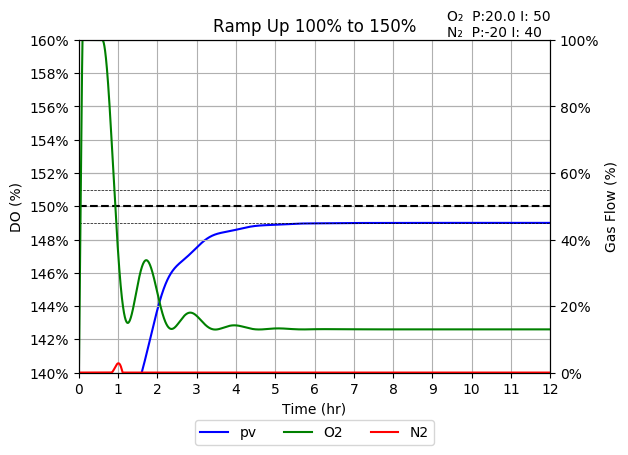

In [24]:
#### Export figures for report

setup2()
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)
ops.set_point = 150
ops.initial_pv = 100
ops.end = 12*hours


ops.k_mult = 1
run2(ops)
ax1.set_xlim(0, 12)
ax1.set_ylim(140, 160)
a,b = ax2.set_ylim()
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax2.set_ylim(0, 1)
ax1.set_title("Ramp Up 100% to 150%")
ax1.text(.7, .91, "O\u2082  P:%.1f I:%3d\nN\u2082  P:%3d I:%3d"%(o2p, o2i, n2p, n2i), transform=fig.transFigure)
path = 'C:\\PBSCloudStation\\(2) R&D-Product Engineering\\Software Development\\3.0 Project\\Phase 2 Working Copy\\IE00005 PID Tuning\\IE00005-06 DO\\Raw Data'
fig.savefig(path+"\\80L ramp up new 170731.png")
fig

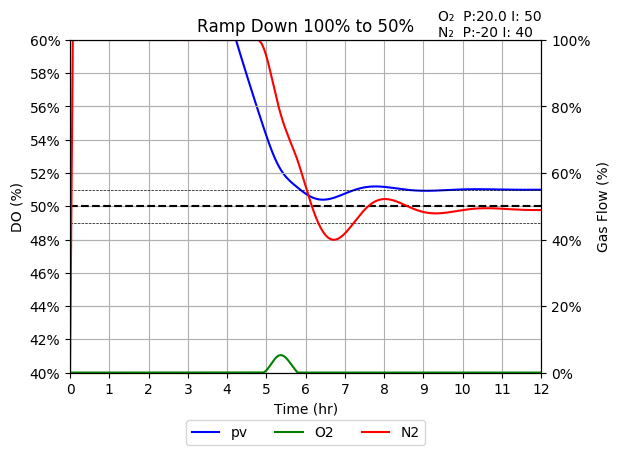

In [25]:
setup2()
ops.set_point = 50
ops.initial_pv = 100
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)

ops.k_mult = 1
run2(ops)
ax1.set_xlim(0, 12)
ax1.set_ylim(40, 60)
ax2.set_ylim(0, 1)
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.set_title("Ramp Down 100% to 50%")
ax1.text(.7, .91, "O\u2082  P:%.1f I:%3d\nN\u2082  P:%3d I:%3d"%(o2p, o2i, n2p, n2i), transform=fig.transFigure)
path = 'C:\\PBSCloudStation\\(2) R&D-Product Engineering\\Software Development\\3.0 Project\\Phase 2 Working Copy\\IE00005 PID Tuning\\IE00005-06 DO\\Raw Data'
fig.savefig(path+"\\80L ramp down new 170731.png")
fig